In [18]:
from helpers import load_CSD_data, make_element_wise_environments
from rascal.utils import get_optimal_radial_basis_hypers

In [19]:
#------loading subsample of dataset--------

PATH_TRAIN = "CSD-2k_relaxed_shifts.txt"
PATH_TEST = "CSD-500.txt"
structures_test, shifts_test = load_CSD_data(PATH_TEST,prop_string="CS")
structures_train, shifts_train = load_CSD_data(PATH_TRAIN,prop_string="CS",random_subsample=400)

In [20]:
shifts_train.shape

(38876,)

In [23]:
from rascal.representations import SphericalInvariants

"""hypers = {"soap_type": "PowerSpectrum",
          "interaction_cutoff": 3,
          "radial_basis": "GTO",
          "max_radial": 9,
          "max_angular": 9,
          "gaussian_sigma_constant": 0.3,
          "gaussian_sigma_type":"Constant",
          "cutoff_function_type":"ShiftedCosine",
          "cutoff_smooth_width": 0.5,
          "normalize": True,
          "compute_gradients":False,
          "cutoff_function_parameters":dict(rate=1,scale=3.5,exponent=4),
          #"optimization": dict(Spline=dict(accuracy=1.0e-05))
          #"expansion_by_species_method":'structure wise'
         }"""


hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=12,
              max_angular=9,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.0,
                            exponent=6
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )

In [24]:
hypers = get_optimal_radial_basis_hypers(hypers, structures_train, expanded_max_radial=20)

In [25]:
calculator = SphericalInvariants(**hypers)

In [6]:
shifts_train.shape

(18844,)

In [26]:
import numpy as np

In [27]:
def make_element_wise_environments_DEBUG(calculator,frames,y=None,select=False):
    """Returns shifts and environments of only one atomtype from the atoms in frames. 
       Or returns a dictionary of atomic-type-wise 
    
    Parameters
    ----------
    calculator : rascal.representations calculator object
                 calculator object with hyperparameters 
    
    frames     : list of ase.atoms objects
                 wrapped structures of the dataset
    
    y          : numpy array of shape (N_environments,X)
                 array of atomic properties
                 
    select     : int
                 atomic number to select atomic species
    Returns
    -------
    
    X_element_wise: dict or numpy.array
                    either dict with atomic numbers keys containing the representations in numpy array, 
                    or numpy array with representations of the selected atomic species
    y_element_wise: dict or numpy.array
                    either dict with atomic numbers keys containing the shifts in numpy arrays, 
                    or numpy array with representations of the selected atomic species
    
    """
    
    
    #get unique elements 
    y_element_wise = {}
    X_element_wise = {}
    
    atoms_list = calculator.transform(frames)
    X_repr = atoms_list.get_features(calculator)
    
    elements = np.unique(atoms_list.get_representation_info()[:,2])
    

    for element in elements:
        
        ind = atoms_list.get_representation_info()[:,2] == element
        print(ind.shape)
        if y is not None:
            y_element_wise[element] = y[ind]
        X_element_wise[element] = X_repr[ind]
    
    #TODO: Change this not to loop over array
    if select is not None:
        return X_element_wise[select], y_element_wise[select] 
    else:
        return X_element_wise, y_element_wise

In [95]:
H_environments_train, H_shifts_train = make_element_wise_environments_DEBUG(calculator,structures_train,shifts_train,select=1)

(38639,)
(38639,)
(38639,)
(38639,)


In [79]:
H_environments_train.shape

(15759, 14400)

In [52]:
from rascal.models.kernels import Kernel

In [73]:
print("%d megabytes" % (H_environments_train.size/1e06 * H_environments_train.itemsize))

1815 megabytes


In [120]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.kernel_approximation import Nystroem


import numpy as np

feature_map_nystroem = Nystroem(kernel='poly', degree=1, coef0=0,
                                random_state=1,
                                n_components=5000)
data_transformed = feature_map_nystroem.fit_transform(H_environments_train)

clf = KernelRidge(alpha=1e-06,kernel='poly', degree=1, coef0=0)
clf.fit(data_transformed, H_shifts_train)

KernelRidge(alpha=1e-06, coef0=0, degree=1, kernel='poly')

In [121]:
from sklearn.linear_model import Ridge

In [122]:
clf_r = Ridge(alpha=1e-06)
clf_r.fit(data_transformed, H_shifts_train)

Ridge(alpha=1e-06)

In [124]:
this = feature_map_nystroem.transform(H_environments_test)

In [125]:
this.shape

(29913, 5000)

In [130]:
y_pred_r = clf_r.predict(this)

In [103]:
type(data_transformed)

numpy.ndarray

In [97]:
#eval
structures_test, shifts_test = load_CSD_data(PATH_TEST,prop_string="CS")
H_environments_test, H_shifts_test = make_element_wise_environments(calculator,structures_test,shifts_test,select=1)

In [115]:
y_predicted

array([28.31409454, 28.31412571, 28.02520698, ..., 28.9863817 ,
       28.98607999, 28.98601864])

In [105]:
y_predicted = clf.predict(H_environments_test)

ValueError: X has 14400 features, but KernelRidge is expecting 300 features as input.

In [14]:
len(H_shifts_test)

29913

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
np.sqrt(2*mean_squared_error(H_shifts_test[:,0], np.array(y_predicted),squared=True))

1.2555840046457893

In [129]:
this.shape

(29913, 5000)

In [131]:
mean_squared_error(H_shifts_test[:,0], np.array(y_pred_r),squared=False)

0.6324281408865559

In [127]:
mean_squared_error(H_shifts_test[:,0], np.array(y_predicted),squared=False)

0.638373252018703

In [57]:
mean_squared_error(H_shifts_test[:,0], np.array(y_predicted),squared=False)

0.8878319640343992

In [33]:
y_predicted

array([27.38763038, 27.38770087, 27.04081473, ..., 29.39186921,
       29.39274163, 29.39274741])

In [100]:
mean_absolute_error(H_shifts_test[:,0],y_predicted)

0.4834180165276096

In [78]:
mean_absolute_error(H_shifts_test[:,0],y_predicted)

0.48924993222347224

In [30]:
def optimize_hypers(X_train,X_test,y_train,y_test,y_ML_old,alphas=np.logspace(-8, 0, num=25)):
    errors = []
    errors_ml = []
    
    for val in alphas:
        clf = KernelRidge(alpha=val, degree=2)
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)
        errors.append(np.sqrt(2*mean_squared_error(y_predicted, y_test,squared=True)))
        errors_ml.append(np.sqrt(2*mean_squared_error(y_ML_old, y_predicted,squared=True)))
    return errors, errors_ml, alphas
    
    
    

In [16]:
from sklearn.kernel_approximation import Nystroem

In [17]:
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=10)

In [18]:
data = feature_map_nystroem.fit_transform(H_environments_test)


In [19]:
data.shape

(29913, 10)

In [20]:
data_transformed = feature_map_nystroem.fit_transform(H_environments_train)

In [60]:
from scipy.optimize import curve_fit

In [61]:
def from_msk_to_radial_scaling(weights,cutoffs):
    pass

In [62]:
def scaling_func(r,r0,m):
    return 1/(1+(r/r0)**m)

In [90]:
A = np.linspace(0,10,num=50)
g = np.vectorize(scaling_func)
B = g(A,3.0,6)

In [64]:
import matplotlib.pyplot as plt

In [80]:
kernel = np.array([256,128,32,8,8,1])
kernel = kernel/np.max(kernel)

In [82]:
distances = np.array([2,3,4,5,6,7])

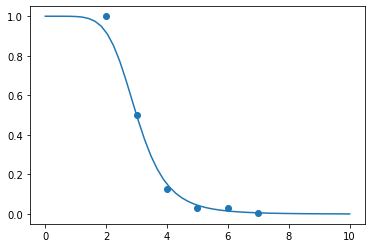

In [91]:
plt.plot(A,B)
plt.scatter(distances,kernel)